# Doodle Detection 
This notebook will help you recreate our entire training process and setup your data for you. No additional files or data required. These are the things the note book will help you execute.

1. Attach your Google Drive to the Colab instance to use as persistence storage
2. Test your Google Drive link
3. Download the data from kaggle CLI
4. Unzip the data
5. Calculate Image entropy per class and append it to the dataset 
6. Create compressed and shuffled gz files to be used with the Image generator 
7. Imports relevant libraries
8. Create image Generator
9. Create Model and specify hyperparameters 
10. Train your model with learning rate scheduling and model checkpoints 
11. Run the model through the kaggle test set
12. Create the submission file for kaggle and save it to your Google Drive 



## Attach Google Drive
After executing the cell below, click on the link below to authorize and get your code.

In [0]:
# Authorise your google account 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Testing Google Drive Mount

In [0]:
# File should be saved on your google drive under the folder colab_output
with open('/content/gdrive/My Drive/colab_output/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/My\ Drive/colab_output/foo.txt

Hello Google Drive!

## Setting up Kaggle Auth & Downloading Data

### You need to place your own username and your API token for kaggle in the cell below

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
# Change to your own key, go to account page, create API token and look inside JSON for key
!echo '{"username":"<YOUR USERNAME HERE>","key":"<YOUR TOKEN HERE>"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Only Download train_simplified
!mkdir -p data
!kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip -p data
!mkdir data/train_simplified

100% 7.36G/7.37G [02:32<00:00, 53.5MB/s]
100% 7.37G/7.37G [02:32<00:00, 51.9MB/s]


In [0]:
# Unzipping takes awhile
!unzip data/train_simplified.zip -d data/train_simplified

Archive:  data/train_simplified.zip
  inflating: data/train_simplified/fence.csv  
  inflating: data/train_simplified/yoga.csv  
  inflating: data/train_simplified/horse.csv  
  inflating: data/train_simplified/sandwich.csv  
  inflating: data/train_simplified/cat.csv  
  inflating: data/train_simplified/camouflage.csv  
  inflating: data/train_simplified/mosquito.csv  
  inflating: data/train_simplified/see saw.csv  
  inflating: data/train_simplified/onion.csv  
  inflating: data/train_simplified/grapes.csv  
  inflating: data/train_simplified/chandelier.csv  
  inflating: data/train_simplified/stitches.csv  
  inflating: data/train_simplified/sink.csv  
  inflating: data/train_simplified/trumpet.csv  
  inflating: data/train_simplified/cell phone.csv  
  inflating: data/train_simplified/skyscraper.csv  
  inflating: data/train_simplified/hourglass.csv  
  inflating: data/train_simplified/donut.csv  
  inflating: data/train_simplified/ceiling fan.csv  
  inflating: data/train_simplif

In [0]:
# Remove zip file to free up space
!rm data/train_simplified.zip


## Create Shuffle CSVs

In [0]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import json
import os
import shutil
import pprint
import datetime as dt
from tqdm import tqdm
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np

In [0]:
def f2cat(filename: str) -> str:
    return filename.split('.')[0]

class Simplified():
    def __init__(self, input_path='/data'):
        self.input_path = input_path

    def list_all_categories(self):
        files = os.listdir(os.path.join(self.input_path, 'train_simplified'))
        return sorted([f2cat(f) for f in files], key=str.lower)

    def read_training_csv(self, category, nrows=None, usecols=None, drawing_transform=False):
        df = pd.read_csv(os.path.join(self.input_path, 'train_simplified', category + '.csv'),
                         nrows=nrows, parse_dates=['timestamp'], usecols=usecols)
        if drawing_transform:
            df['drawing'] = df['drawing'].apply(json.loads)
        return df
   
# Count number rows   
def sum1forline(filename):
    with open(filename) as f:
        return sum(1 for line in f)

In [0]:
# No of Categories 

start = dt.datetime.now()
s = Simplified('data')
NCSVS = 100
categories = s.list_all_categories()

no_rows = 30000
print(len(categories))

340


In [0]:
# # Count number of rows for each category
# for y, cat in tqdm(enumerate(categories)):
#   print(sum1forline('data/train_simplified/'+cat+'.csv'))

In [0]:
for y, cat in tqdm(enumerate(categories)):
    df = s.read_training_csv(cat, nrows=no_rows)
    df['y'] = y
    df['cv'] = (df.key_id // 10 ** 7) % NCSVS
    for k in range(NCSVS):
        filename = 'train_k{}.csv'.format(k)
        chunk = df[df.cv == k]
        chunk = chunk.drop(['key_id'], axis=1)
        if y == 0:
            chunk.to_csv(filename, index=False)
        else:
            chunk.to_csv(filename, mode='a', header=False, index=False)

340it [05:41,  1.07it/s]


In [0]:
for k in tqdm(range(NCSVS)):
    filename = 'train_k{}.csv'.format(k)
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        df['rnd'] = np.random.rand(len(df))
        df = df.sort_values(by='rnd').drop('rnd', axis=1)
        df.to_csv(filename + '.gz', compression='gzip', index=False)
        os.remove(filename)
print(df.shape)

100%|██████████| 100/100 [50:31<00:00, 30.31s/it]

(102042, 7)


In [0]:
# Move all gz to shuffle_csvs
!mkdir shuffle_csvs
!mv *.gz shuffle_csvs


## Model Training

In [0]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()

Using TensorFlow backend.


In [0]:
# Change Paths appropriately
DP_DIR = 'shuffle_csvs/'
INPUT_DIR = 'data/'

# Google Drive location
OUTPUT_PATH = "/content/gdrive/My Drive/colab_output/"

# Hyperparameters
BASE_SIZE = 256
NCSVS = 100
NCATS = 340

STEPS = 800
EPOCHS = 16
size = 64
batchsize = 560
stroke_shade = 13 # The amount to lighten the subsequent strokes by

# Name this experiment 
exp_name= "mk1"
description= "Testing"


# Seed initialisation
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)


In [0]:
# Initialise CSV Logger 
csv_logger = CSVLogger(OUTPUT_PATH+exp_name+'.csv', append=True, separator=',')

In [0]:
def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [0]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

## Model
Comment out the code block if TPU or GPU

In [0]:
# Clear past graphs and memory
tf.keras.backend.clear_session()

## Using GPU

model = ResNet50(input_shape=(size, size, 1), weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

## Image Generator

In [0]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            # For the first 10 strokes reduce each stroke by x(stroke_shade) points
            color = 255 - min(t, 10) * stroke_shade if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [0]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=60000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(60000, 64, 64, 1) (60000, 340)
Validation array memory 0.92 GB


In [0]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

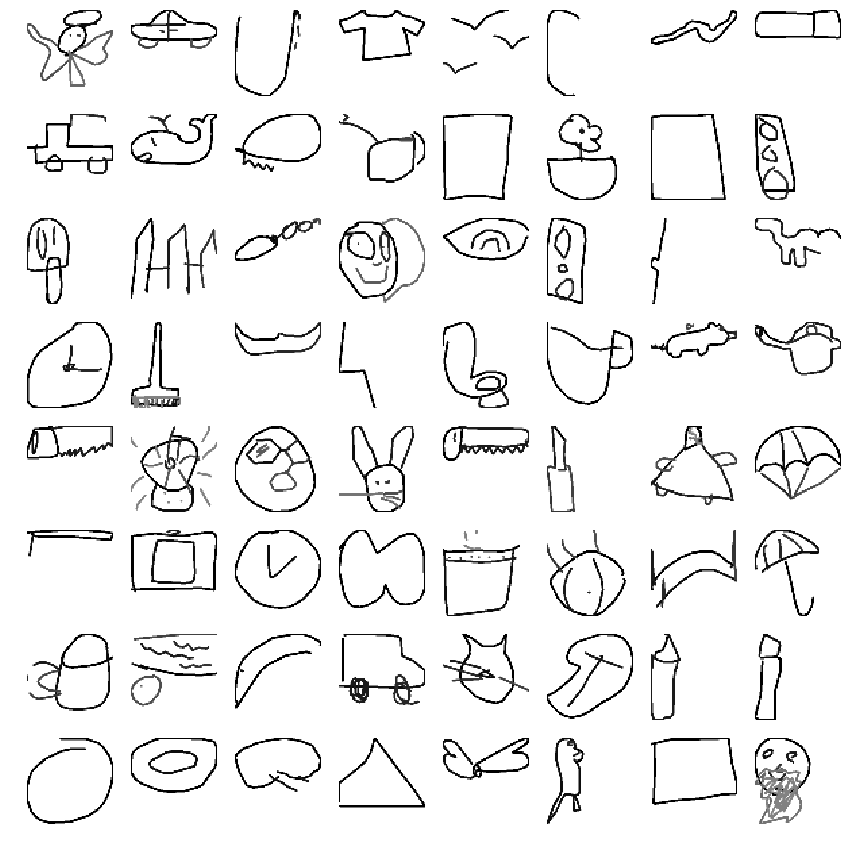

In [0]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [0]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1),
    ModelCheckpoint(OUTPUT_PATH+exp_name+'.h5', monitor='val_categorical_accuracy', verbose=0, save_best_only=True),
    csv_logger,
    
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)



Epoch 1/16
800/800 [==============================] - 1150s 1s/step - loss: 2.6396 - categorical_crossentropy: 2.6396 - categorical_accuracy: 0.4128 - top_3_accuracy: 0.6034 - val_loss: 2.8466 - val_categorical_crossentropy: 2.8466 - val_categorical_accuracy: 0.3991 - val_top_3_accuracy: 0.5850
Epoch 2/16
800/800 [==============================] - 1119s 1s/step - loss: 1.6492 - categorical_crossentropy: 1.6492 - categorical_accuracy: 0.6013 - top_3_accuracy: 0.7949 - val_loss: 1.8604 - val_categorical_crossentropy: 1.8604 - val_categorical_accuracy: 0.5493 - val_top_3_accuracy: 0.7554
Epoch 3/16
800/800 [==============================] - 1121s 1s/step - loss: 1.4416 - categorical_crossentropy: 1.4416 - categorical_accuracy: 0.6477 - top_3_accuracy: 0.8309 - val_loss: 1.4633 - val_categorical_crossentropy: 1.4633 - val_categorical_accuracy: 0.6368 - val_top_3_accuracy: 0.8237
Epoch 4/16
340/800 [===========>..................] - ETA: 10:17 - loss: 1.3604 - categorical_crossentropy: 1.36

In [0]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [0]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

In [0]:
#Save to result to google drive with hyperparameters

map3_str= str(round(map3,3))

hyperparameters_details = str( 'STEPS:'+str(STEPS)+'  EPOCHS:'+str(EPOCHS)+'  Size:'+str(size)+'  Batchsize:'+str(batchsize) )
with open('/content/gdrive/My Drive/colab_output/results-'+exp_name+'__'+map3_str+'.txt', 'w') as f:
  f.write(hyperparameters_details)


## Create Submission

In [0]:
# Download Test CSV
!kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv
!mv test_simplified.csv data

In [0]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

In [0]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

In [0]:
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('submission-'+exp_name+'.csv', index=False)
submission.head()
submission.shape

In [0]:
# Save Submission to Google Drive

sub_filename='submission-'+exp_name+'.csv'

shutil.move(sub_filename, OUTPUT_PATH+sub_filename)